# Meter estimation on symbolic data

Meter, time signature, beat, downbeat, and tempo estimation form a group of related tasks. At first glance, many of them might seem trivial on symbolic music, after all the precise onsets of notes are known from the MIDI data. But with changing tempi and unknown measures it can be quite challenging. 

In [55]:
import partitura as pt
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [56]:
path_to_midi = os.path.join("..","introduction","example_data","Chopin_op10_no3_p01.mid")
ppart = pt.load_performance_midi(path_to_midi)

In [57]:
note_array = ppart.note_array

In [58]:
IOIs = np.diff(np.sort(note_array["onset_sec"]))

(array([119.,  79.,  38.,  22.,  17.,   5.,   4.,   3.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   3.,   5.,   5.,   5.,   6.,  16.,   9.,
         10.,   9.,  10.,   5.,  10.,  10.,   5.,   5.,   6.,   3.,   3.,
          5.,   3.,   1.,   5.,   2.,   1.,   1.,   1.,   2.,   1.,   4.,
          0.,   1.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.00967499, 0.01934998, 0.02902496, 0.03869995,
        0.04837494, 0.05804993, 0.06772491, 0.0773999 , 0.08707489,
        0.09674988, 0.10642487, 0.11609986, 0.12577485, 0.13544983,
        0.14512482, 0.1547998 , 0.16447479, 0.17414978, 0.18382476,
        0.19349976, 0.20317474, 0.21284974, 0.

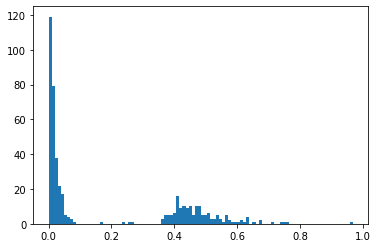

In [59]:
plt.hist(IOIs, bins = 100)

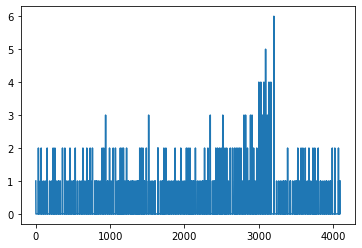

In [60]:
# convert the measured onsets to a framed unidimensional signal that 
#contains the number of onsets in a performance in a small window in time, e.g. 20 ms 

FRAMERATE = 50

onset_min = note_array["onset_sec"].min()
onset_max = note_array["onset_sec"].max()

onset_duration = onset_max - onset_min
frames = np.zeros(int(onset_duration*FRAMERATE)+1)
for note in note_array:
    frames[int((note["onset_sec"]-onset_min)*FRAMERATE)] += 1
    
plt.plot(frames)

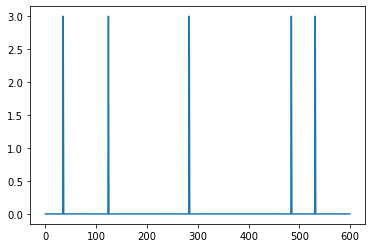

In [61]:
# a differenct frame generation process
aggregated_notes = [(0,0)]
CHORD_SPREAD_TIME = 1/12 # a little faster than 16th notes at 180 bpm
for note in ppart.notes:
    prev_note_on = aggregated_notes[-1][0]
    note_on = note["note_on"]
    prev_note_vel = aggregated_notes[-1][1]
    if abs(note_on - prev_note_on) < CHORD_SPREAD_TIME:
        aggregated_notes[-1] = (note_on, prev_note_vel + 1) #note["velocity"]
        
    else:
        aggregated_notes.append((note_on, 1))
    
frames_a = np.zeros(int(onset_duration*FRAMERATE)+1)
for note in aggregated_notes:
    frames_a[int((note[0]-onset_min)*FRAMERATE)] += note[1]
    
frames_a[frames_a < 2.1] = 0.0
    
plt.plot(frames_a[:600])

In [62]:
# for possible tempi compute autocorrelation 

autocorr = np.zeros((2*FRAMERATE,frames.shape[0])  )

for framediff in range(1, 2*FRAMERATE+1):
    autocorr[framediff-1,framediff:] = frames_a[framediff:]*frames_a[:-framediff]

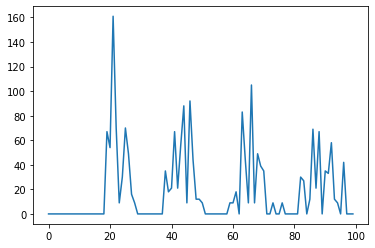

In [63]:
plt.plot(np.sum(autocorr, axis = 1))

In [64]:
# how to interpret these dimensions?
# nomber of frames between onsets is inversely proportional to the tempo of the onsets!

#from scipy.signals import find_peaks
#a = find_peaks(np.sum(autocorr, axis = 1))
m = np.argmax(np.sum(autocorr, axis = 1))
print(FRAMERATE/(m+1)*60)

136.36363636363637


In [65]:
HOPSIZE = 20
WINDOWSIZE = 200
number_of_windows = int((autocorr.shape[1]-WINDOWSIZE)/HOPSIZE)

local_autocorr = np.zeros((autocorr.shape[0],number_of_windows))

for k in range(number_of_windows):
    local_autocorr[:,k] = np.sum(autocorr[:,k*HOPSIZE:k*HOPSIZE+WINDOWSIZE]
, axis = 1)    

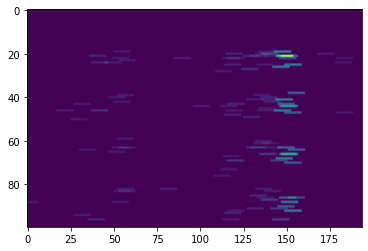

In [66]:
plt.imshow(local_autocorr*10, aspect="auto")